# HW3
Boscato Marco - 2096921

## Exercise 1:
We know from Ch.4 that the equation of the area integral in therms of the true anomaly (Eq. 4.40) can be written as

$$
h = r^2 \dot{f} \quad \rightarrow \quad \dot{f} = \frac{h}{r^2}
$$

where

$$
r = \frac{p}{1 + e \cos f}
$$

since we want to find the maximum deceleration given by $-\ddot{f}$, we derivate $\dot{f}$ two times to find the maximum value of the function. So we can write

$$
\dot{f} = \frac{h}{r^2} = \frac{h}{p^2} (1+ e \cos f)^2 \\
\ddot{f} = - 2 \frac{h}{p^2}(1+ e \cos f) e \sin f \dot{f} = - 2 \frac{h^2}{p^4}(1+ e \cos f)^3 e \sin f \\
\frac{d^3 f}{dt^3} = - 2 \frac{h^2 e}{p^4} \left[- 3(1+ e \cos f)^2 e \sin^2 f \dot{f} + (1+ e \cos f)^3 \cos f \dot{f} \right] = - 2 \frac{h^2 e}{p^4} (1+ e \cos f)^2 \left[- 3 e \sin^2 f + (1+ e \cos f) \cos f \right] \dot{f}
$$
imposing $\frac{d^3 f}{dt^3} = 0$ to find the maximum point we get

$$
0 = - 3 e \sin^2 f + (1+ e \cos f)\cos f = - 3 e \sin^2 f + \cos f + e \cos^2 f = - 3 e + 3\cos^2 f + \cos f + e \cos^2 f\\
e = \frac{\cos f}{3 - 4 \cos^2 f}
$$

and for $f = \pi / 4$ we get $e = \sqrt{2}/2$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import pandas as pd


# Constants
AU = 149597870707 #Astronomical Unit in m
G = 6.6743e-11
M_sun = 1.9891e30
mu = G*M_sun  #Gravitational parameter of the Sun
R_Earth = 6.378137e6  #Radius of the spherical Earth

#Latitude and longitude of Padua
long_PD = np.deg2rad(11 + 52.3/60)
lat_PD = np.deg2rad(45 + 24/60)

## Exercise 2:
the rotation matrix that transform inversily from Laplace to in ertial is the direct transposition of the matrix calculated above, basically

$$
r_{[L]} = R(\omega, i, \Omega) r_{[I]} \\
r_{[I]} = R^T (\omega, i, \Omega) r_{[L]}
$$

explicity it will be:

$$
x = a[(\cos \Omega \cos \omega - \sin \Omega \sin \omega \cos i)(\cos E - e) - (\cos \Omega \sin \omega + \sin \Omega \cos w \cos i)\sqrt{1 -e^2} \sin E] \\
y = a[(\sin \Omega \cos \omega + \cos \Omega \sin \omega \cos i)(\cos E - e) - (\sin \Omega \sin \omega - \cos \Omega \cos w \cos i)\sqrt{1 -e^2} \sin E] \\
z = a[\sin \omega \sin i (\cos E - e) + \cos \omega \sin i \sqrt{1 - e^2} \sin E]
$$

and the velocity transformation is obtained by deriving with respect to time:

$$
\dot{x} = - \frac{na^2}{r}[(\cos \Omega \cos \omega - \sin \Omega \sin \omega \cos i)\sin E + (\cos \Omega \sin \omega + \sin \Omega \cos w \cos i)\sqrt{1 -e^2} \cos E] \\
\dot{y} = - \frac{na^2}{r}[(\sin \Omega \cos \omega + \cos \Omega \sin \omega \cos i)\sin E + (\sin \Omega \sin \omega - \cos \Omega \cos w \cos i)\sqrt{1 -e^2} \cos E] \\
\dot{z} = - \frac{na^2}{r}[\sin \omega \sin i \sin E - \sqrt{1 - e^2} \cos \omega \sin i \cos E]
$$

to calculate the *eccentric anomaly E* we use a Newton-Raphson method given

$$
M = L - \pi \\
0 = E - e\sin E - M
$$

In [3]:
'''Reading the data from the file Elementi Orbitali (Meeus - MEE of date).m'''

# I modified a little the .m file to obtain a organized table
df = pd.read_csv('Elementi Orbitali (Meeus - MEE of date).m', delimiter='\s+', comment='%', header=None, usecols=[0,1,2,3])

planet_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']

planets = {}
for i, name in enumerate(planet_names):
  #Save the orbital elements in a dictionary. blocks of 6 rows at every time because each planet has 6 orbital elements
  orbital_elements = {}
  orbital_elements['L'] = np.deg2rad(np.array(df.iloc[6*i])) # convert to radians since numpy.cos and numpy.sin take radians as input
  orbital_elements['a'] = np.array(df.iloc[6*i+1])*AU   #Convert from AU to m
  orbital_elements['e'] = np.array(df.iloc[6*i+2])
  orbital_elements['i'] = np.deg2rad(np.array(df.iloc[6*i+3]))
  orbital_elements['Omega'] = np.deg2rad(np.array(df.iloc[6*i+4]))
  orbital_elements['pi'] = np.deg2rad(np.array(df.iloc[6*i+5]))

  #Save the dictionary with the planet name
  planets[name]=orbital_elements

In [5]:
def Newton_Raphson(M,e, atol=1e-14):
    '''Solving eccentric anomaly's equation'''
    # This works only if M is between 0 and 2pi, so I have to rescalate it
    k = np.floor(M/(2*np.pi))
    M = M-k*2*np.pi           #Subtract all the complete orbits
    E = M
    Delta = 1e2
    while(Delta > atol):
        Delta = (E - e*np.sin(E) - M)/(1-e*np.cos(E))
        E = E - Delta
    return E

Function taken from the example 31.a in the *Elementi_Orbitali_Meeus* PDF

In [6]:
def orbital_elements_time_corrected(dat, Time):
    a0, a1, a2, a3 = dat[0], dat[1], dat[2], dat[3]
    return a0 + a1*Time + a2*Time**2 + a3*Time**3

And here we proceed by developing the function to convert in Cartesian coordinates

In [8]:
def laplace_to_inertial(planet_name, t):
    orbital_elements = planets[planet_name]

    L = orbital_elements_time_corrected(orbital_elements['L'], t)
    a = orbital_elements_time_corrected(orbital_elements['a'], t)
    e = orbital_elements_time_corrected(orbital_elements['e'], t)
    i = orbital_elements_time_corrected(orbital_elements['i'], t)
    Omega = orbital_elements_time_corrected(orbital_elements['Omega'], t)
    w = orbital_elements_time_corrected(orbital_elements['pi'], t)

    M = L - w
    n = np.sqrt(mu/a**3.)  # mean motion

    # Eccentric anomaly (E) by Newton-Raphson method
    E = Newton_Raphson(M,e)
    r = a*(1-e*np.cos(E))

    # position 
    x = a*((np.cos(Omega)*np.cos(w) - np.sin(Omega)*np.sin(w)*np.cos(i))*(np.cos(E) - e) - (np.cos(Omega)*np.sin(w) + np.sin(Omega)*np.cos(w)*np.cos(i))*np.sqrt(1-e**2.)*np.sin(E))
    y = a*((np.sin(Omega)*np.cos(w) + np.cos(Omega)*np.sin(w)*np.cos(i))*(np.cos(E) - e) - (np.sin(Omega)*np.sin(w) - np.cos(Omega)*np.cos(w)*np.cos(i))*np.sqrt(1-e**2.)*np.sin(E))
    z = a*(np.sin(w)*np.sin(i)*(np.cos(E) - e) + np.cos(w)*np.sin(i)*np.sqrt(1-e**2.)*np.sin(E))

    # velocity
    r = np.sqrt(x**2. + y**2. + z**2.)

    vx = -(n*a**2./r)*((np.cos(Omega)*np.cos(w) - np.sin(Omega)*np.sin(w)*np.cos(i))*np.sin(E) + (np.cos(Omega)*np.sin(w) + np.sin(Omega)*np.cos(w)*np.cos(i))*np.sqrt(1-e**2.)*np.cos(E))
    vy = -(n*a**2./r)*((np.sin(Omega)*np.cos(w) + np.cos(Omega)*np.sin(w)*np.cos(i))*np.sin(E) + (np.sin(Omega)*np.sin(w) - np.cos(Omega)*np.cos(w)*np.cos(i))*np.sqrt(1-e**2.)*np.cos(E))
    vz = -(n*a**2./r)*(np.sin(w)*np.sin(i)*np.sin(E) - np.cos(w)*np.sin(i)*np.sqrt(1-e**2.)*np.cos(E))

    return np.array([x,y,z,vx,vy,vz])


## Exercise 3
First of all we have to convert each day at 23h of 2024 in JDE and then calculate *T* for every one of them

$$
T = \frac{JDE - 2451545.0}{36525}
$$

We know from a converter that 01/01/2024 at 23h is 2460311.45833 and we know that the day after at the same hour will increment by 1, so we can immediately have the JD for each day of 2024.
From `data.py` we get all the orbit parameters obtained on Jannuary 1 2000 at 12 h UT so that we can calculate the new orbit parameter by the formula

$$
a_0 + a_1 T + a_2 T^2 + a_3 T^3
$$

where T is the time measured in Julian centuries in 36525 ephemeris days from the epoch J2000.0

In [9]:
JD_start = 2460311.45833
JD_end = 2460311.45833 + 365

JD_days = np.linspace(JD_start, JD_end, 365)
T = np.zeros_like(JD_days)

for i, jd in enumerate(JD_days):
    T[i] = (jd - 2451545.0)/36525.


In [10]:
''' Conversion to cartesian coordinates '''

planets_orbits_cartesian = np.zeros([8, len(T), 6], float)

for i, name in enumerate(planet_names):
    for j in range(len(T)):
        planets_orbits_cartesian[i, j] = laplace_to_inertial(name, T[j])

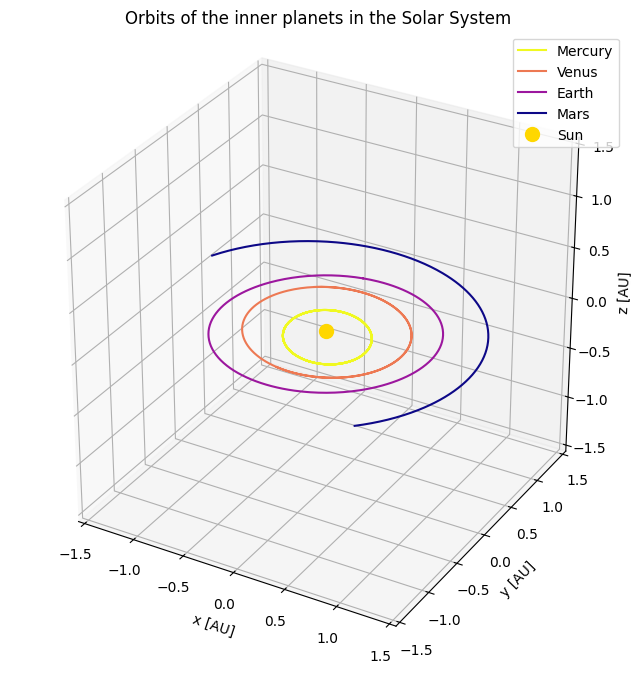

In [21]:
#plot 3d orbits
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
colors = cmap.plasma_r(np.linspace(0,1,4))
for p in range(4):
    ax.plot(planets_orbits_cartesian[p,:,0]/AU, planets_orbits_cartesian[p,:,1]/AU, planets_orbits_cartesian[p,:,2]/AU, color=colors[p], label=planet_names[p])
ax.plot(0, 0, 0, 'o', label='Sun', color='gold', markersize=10)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.5,1.5])
ax.set_xlabel('x [AU]')
ax.set_ylim([-1.5,1.5])
ax.set_ylabel('y [AU]')
ax.set_zlim([-1.5,1.5])
ax.set_zlabel('z [AU]')
plt.title('Orbits of the inner planets in the Solar System')
plt.legend()
plt.show()

## Exercise 4
To compute the azimuth $A$ and elevation $h$ for a specified Earth location, it is first necessary to reduce the equatorial coordinates from heliocentric to geocentric: The geocentric vector **r'** that describes the position of the celestial body results from the translation

$$
r'_{geo} = r - r_{\oplus}
$$

And then we have to rotate the reference system so that it is aligned with the Earth's equator by an angle equal to the *mean obliquity*

$$
r'_{eq} = R(-\epsilon) r'_{geo}
$$

In order to obtain the coordinates of a celestial body in altitude and azimuth, it is also important to enter the local altitude and azimuth of the observatory, which in our case corresponds to the city of Padova, where the time is calculated at 22h in the local time zone (+1 UTC) 

In [12]:
def eps(t):
  eps = 23.439291 - 0.0130042*t - 0.00059*t**2 + 0.001813*t**3
  return np.deg2rad(eps)

def GMST(t, h, timezone):
    '''Greenwich Mean Sidereal Time'''
    GMST0 = 24110.54841 + 8640184.812866*t + 0.093104*t**2 - 0.0000062*t**3 #GMST at UT1=0
    fraction = (h - timezone)*3600 #  
    GMST = GMST0 + 1.00273790935*fraction #GMST at UT1
    
    return GMST*2*np.pi/(24*3600) #GMST angle in RADIANS

In [13]:
def Rx(theta, v):
  '''Rotation to align to a vector along the x-axis'''
  return np.array([v[0], v[1]*np.cos(theta)+v[2]*np.sin(theta), -v[1]*np.sin(theta)+v[2]*np.cos(theta)])

def Rz(theta, v):
  '''Rotation to align to a vector around the z-axis'''
  return np.array([v[0]*np.cos(theta)+v[1]*np.sin(theta), -v[0]*np.sin(theta)+v[1]*np.cos(theta), v[2]])

In [14]:
def geo_coord(planet_name, t):
    if planet_name == 'Sun': #The Sun has coordinates 0,0,0 in its RF 
        X =  - laplace_to_inertial('Earth', t)
    else:
        X = laplace_to_inertial(planet_name, t) - laplace_to_inertial('Earth', t)
    return X


def Alt_Az(planet_name, t, GMST, lat, long):
  '''Returns the altitude and azimuth in DEGREES'''
  r_GEO = geo_coord(planet_name, t)
  r_AltAz = Rx(np.pi/2-lat, Rz(long+np.pi/2+GMST, Rx(-eps(t), r_GEO)))
  r_AltAz = r_AltAz - np.array([0,0,R_Earth]) #The RF is aligned with the posistion on the surface, then traslated up to it

  # Now the RF is East-North-Up
  Alt = np.rad2deg(np.arctan2(r_AltAz[2],(r_AltAz[0]**2+r_AltAz[1]**2)**0.5))
  Az = np.rad2deg(np.arctan2(r_AltAz[0],r_AltAz[1]))
  Az = Az+360 if Az<0 else Az # The Azimuth is rescaled from -180 180 to 0 360
  return Alt, Az

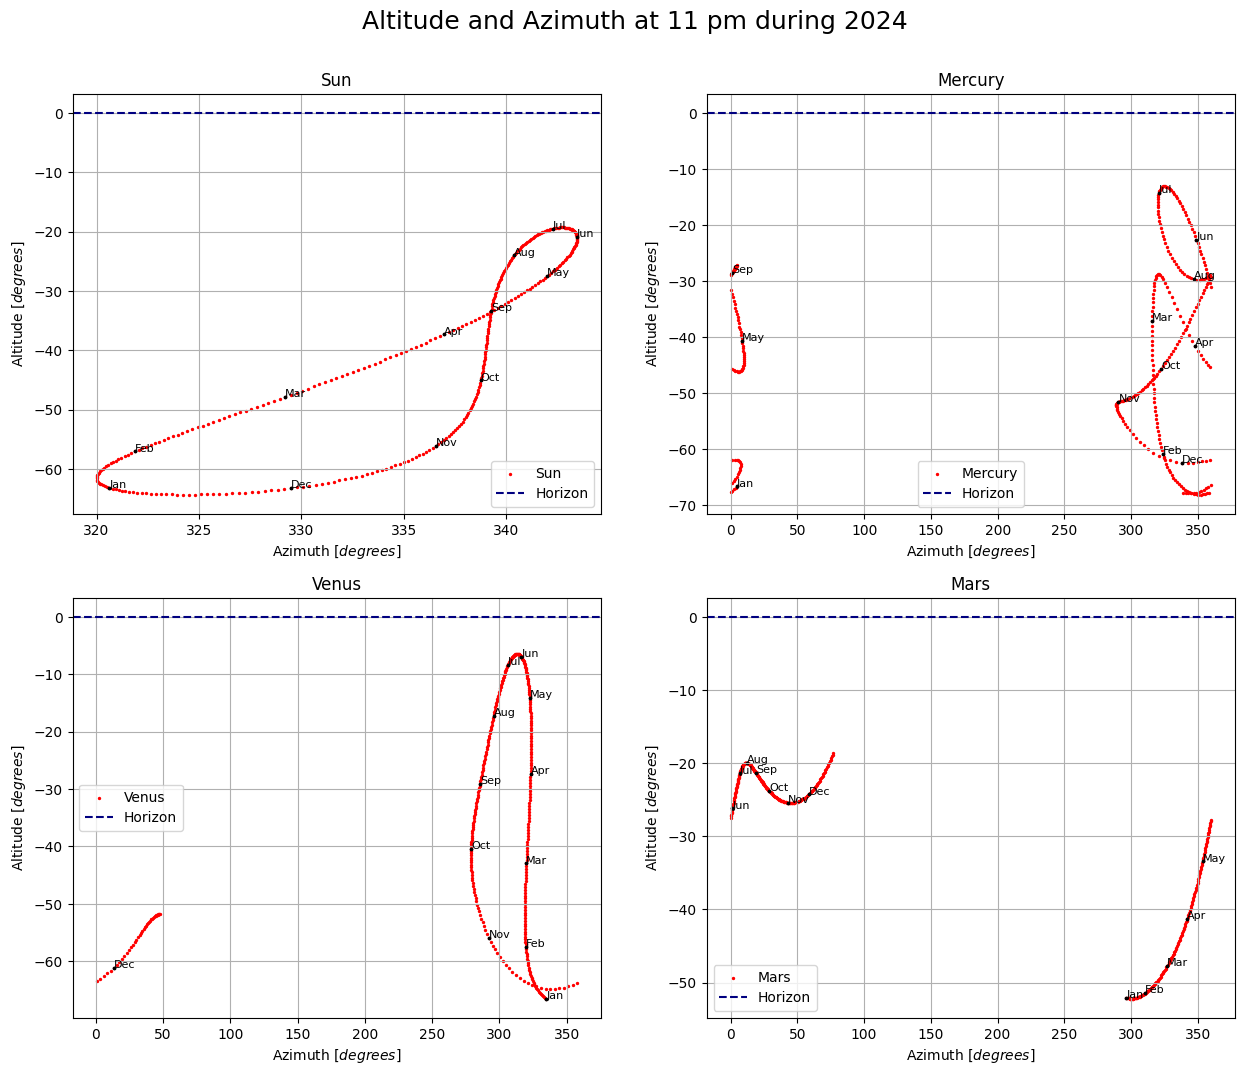

In [15]:
plt.figure(figsize=(15, 12))
plt.suptitle("Altitude and Azimuth at 11 pm during 2024", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


for n, planet_name in enumerate(['Sun', 'Mercury', 'Venus', 'Mars']):
    ax = plt.subplot(2, 2, n + 1)
    ax.set_title(f'{planet_name}')
    coords = np.zeros([len(T), 2])
    for i in range(len(T)):
        # add a new subplot iteratively
        coords[i,:] = np.array([Alt_Az(planet_name, T[i], GMST(T[i], 23, 1), lat_PD, long_PD)])

    ax.scatter(coords[:,1], coords[:,0], color='r', s=2, label=f'{planet_name}')
    ax.axhline(0, color='navy', linestyle='dashed', label='Horizon')

    
    #Plotting the position every 30 days
    for i, month in enumerate(month_names):
        coords = Alt_Az(planet_name, T[i*30], GMST(T[i*30], 23, 1), lat_PD, long_PD)
        ax.scatter(coords[1], coords[0], color='k', s=3)
        ax.text(coords[1], coords[0], f'{month}', fontsize=8)

    ax.grid()
    ax.set_xlabel('Azimuth $[degrees]$')
    ax.set_ylabel('Altitude $[degrees]$')
    ax.legend()

From the plot we can see that no other planet seems to be visible at this time.

## Exercise 5
we procede by usig the function developed previosly but this time focusing only on the Sun and Venus at two different time, 10h UT and 20 h UT. From a converter online we found the the julian Date at January $1^{st}$, 2023 at 10 UT is *2460310.91667* meanwhile at 20h UT is *2460311.33333*. we procede with the same code. As we can see from the plots below the Sun draws the tipical *8-shape* figure called **analemma**

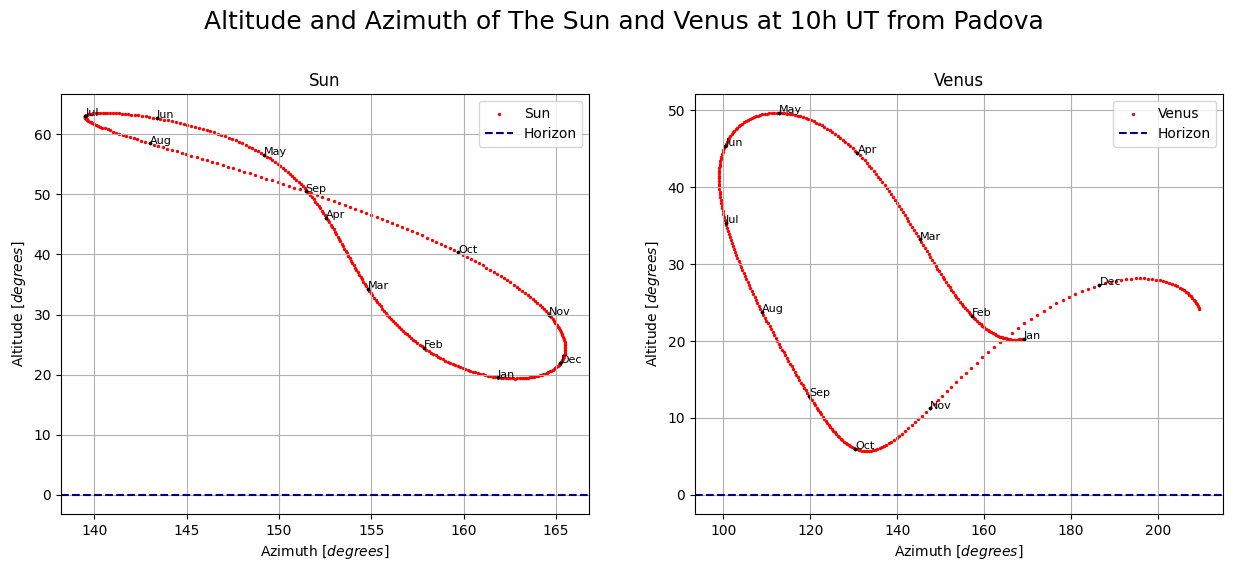

In [16]:
JD_10 = 2460310.91667
JD_20 = 2460311.33333

JD10_days = np.linspace(JD_10, JD_10 + 365, 365)
JD20_days = np.linspace(JD_20, JD_20 + 365, 365)

T10 = np.zeros_like(JD10_days)
T20 = np.zeros_like(JD20_days)

for i, jd in enumerate(JD10_days):
    T10[i] = (JD20_days[i] - 2451545.0)/36525.
    T20[i] = (JD20_days[i] - 2451545.0)/36525.

plt.figure(figsize=(15, 12))
plt.suptitle("Altitude and Azimuth of The Sun and Venus at 10h UT from Padova", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


for n, planet_name in enumerate(['Sun', 'Venus']):
    ax = plt.subplot(2, 2, n + 1)
    ax.set_title(f'{planet_name}')
    coords = np.zeros([len(T10), 2])
    for i in range(len(T10)):
        # add a new subplot iteratively
        coords[i,:] = np.array([Alt_Az(planet_name, T10[i], GMST(T10[i], 10, 0), lat_PD, long_PD)])

    ax.scatter(coords[:,1], coords[:,0], color='r', s=2, label=f'{planet_name}')
    ax.axhline(0, color='navy', linestyle='dashed', label='Horizon')

    
    #Plotting the position every 30 days
    for i, month in enumerate(month_names):
        coords = Alt_Az(planet_name, T10[i*30], GMST(T10[i*30], 10, 0), lat_PD, long_PD)
        ax.scatter(coords[1], coords[0], color='k', s=3)
        ax.text(coords[1], coords[0], f'{month}', fontsize=8)

    ax.grid()
    ax.set_xlabel('Azimuth $[degrees]$')
    ax.set_ylabel('Altitude $[degrees]$')
    ax.legend()

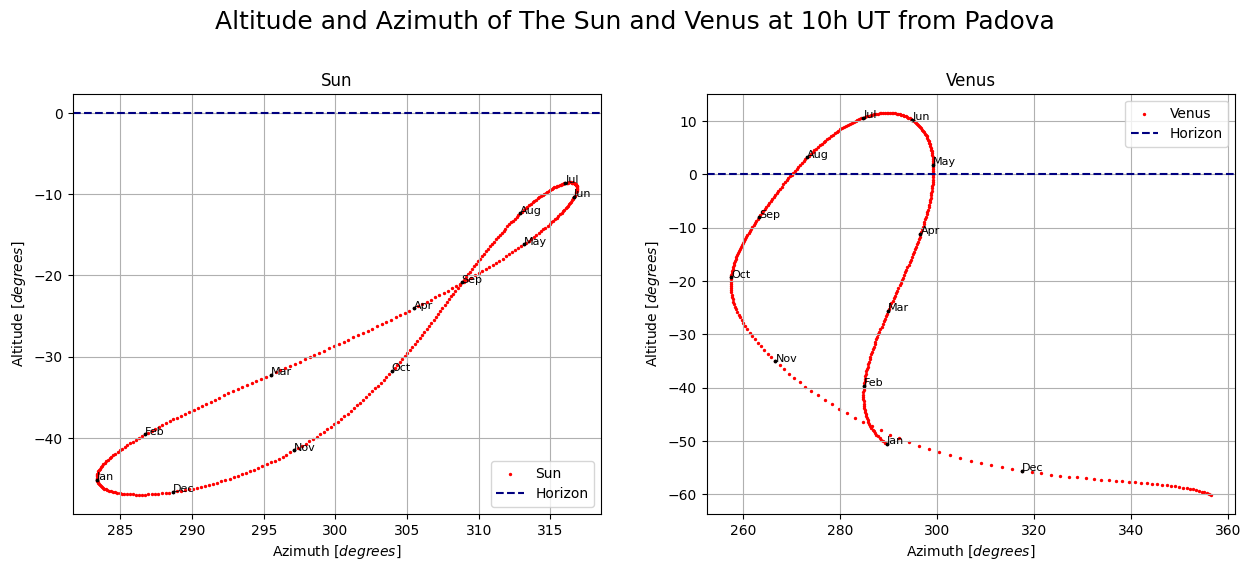

In [17]:
plt.figure(figsize=(15, 12))
plt.suptitle("Altitude and Azimuth of The Sun and Venus at 10h UT from Padova", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


for n, planet_name in enumerate(['Sun', 'Venus']):
    ax = plt.subplot(2, 2, n + 1)
    ax.set_title(f'{planet_name}')
    coords = np.zeros([len(T10), 2])
    for i in range(len(T10)):
        # add a new subplot iteratively
        coords[i,:] = np.array([Alt_Az(planet_name, T10[i], GMST(T20[i], 20, 0), lat_PD, long_PD)])

    ax.scatter(coords[:,1], coords[:,0], color='r', s=2, label=f'{planet_name}')
    ax.axhline(0, color='navy', linestyle='dashed', label='Horizon')

    
    #Plotting the position every 30 days
    for i, month in enumerate(month_names):
        coords = Alt_Az(planet_name, T20[i*30], GMST(T20[i*30], 20, 0), lat_PD, long_PD)
        ax.scatter(coords[1], coords[0], color='k', s=3)
        ax.text(coords[1], coords[0], f'{month}', fontsize=8)

    ax.grid()
    ax.set_xlabel('Azimuth $[degrees]$')
    ax.set_ylabel('Altitude $[degrees]$')
    ax.legend()